In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load the data into different DataFrames
ratings_df = pd.read_csv("ratings.csv")
movies_df = pd.read_csv("movies.csv")

print(ratings_df.head())
print(movies_df.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


## Preprocessing

In [2]:
# merge ratings_df and movies_df
df = pd.merge(ratings_df, movies_df, on='movieId')

# convert timestamp column in df to YYYY-MM-DD HH:MM:SS and rename it
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
# df["timestamp"] = df["timestamp"].dt.strftime("%m-%d-%Y")
df.rename(columns={"timestamp": "date"}, inplace=True)

# check for missing values
missingValues = df.isna().sum()
# print(missingValues) # output proves there are no missing values in any column

# use one-hot encoding for genres
genreDummies = df["genres"].str.get_dummies('|')
df = pd.concat([df, genreDummies], axis=1)

# drop insignificant columns
dropColumns = ["genres", "(no genres listed)"]
df = df.drop(dropColumns, axis=1)

print(df)

        userId  movieId  rating                date  \
0            1        1     4.0 2000-07-30 18:45:03   
1            1        3     4.0 2000-07-30 18:20:47   
2            1        6     4.0 2000-07-30 18:37:04   
3            1       47     5.0 2000-07-30 19:03:35   
4            1       50     5.0 2000-07-30 18:48:51   
...        ...      ...     ...                 ...   
100831     610   166534     4.0 2017-05-03 21:53:22   
100832     610   168248     5.0 2017-05-03 22:21:31   
100833     610   168250     5.0 2017-05-08 19:50:47   
100834     610   168252     5.0 2017-05-03 21:19:12   
100835     610   170875     3.0 2017-05-03 21:20:15   

                                 title  Action  Adventure  Animation  \
0                     Toy Story (1995)       0          1          1   
1              Grumpier Old Men (1995)       0          0          0   
2                          Heat (1995)       1          0          0   
3          Seven (a.k.a. Se7en) (1995)       0     

## Exploratory Data Analysis

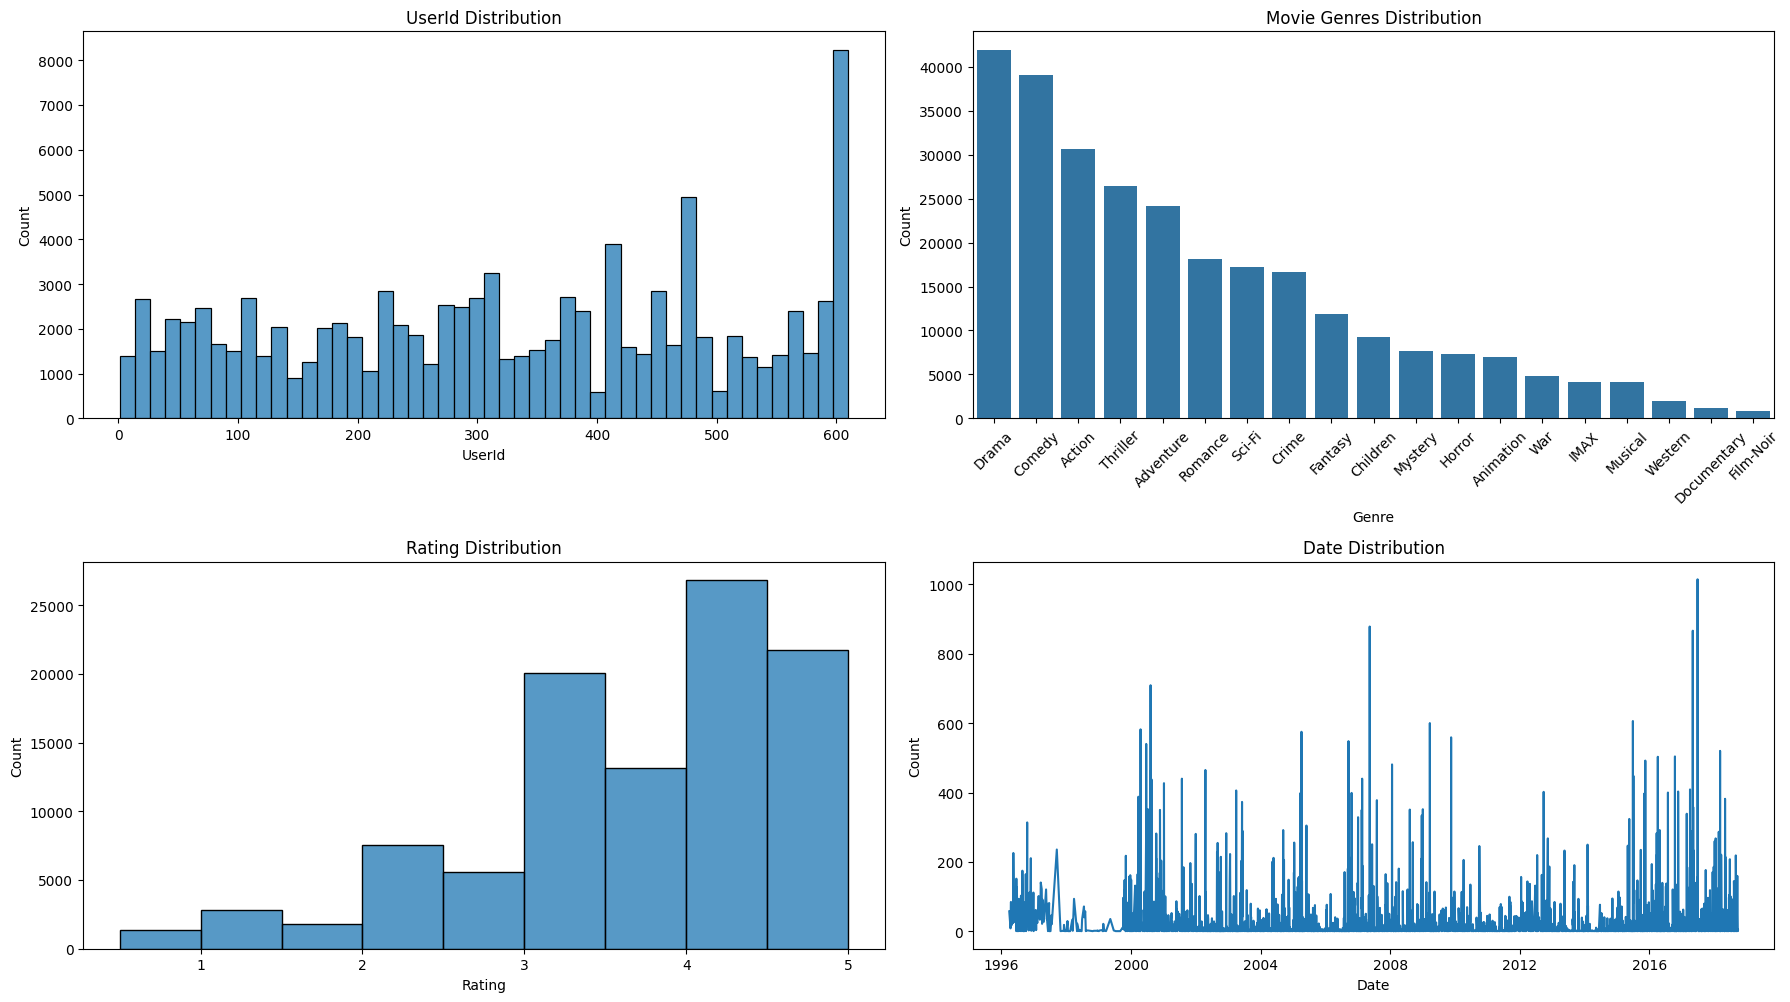

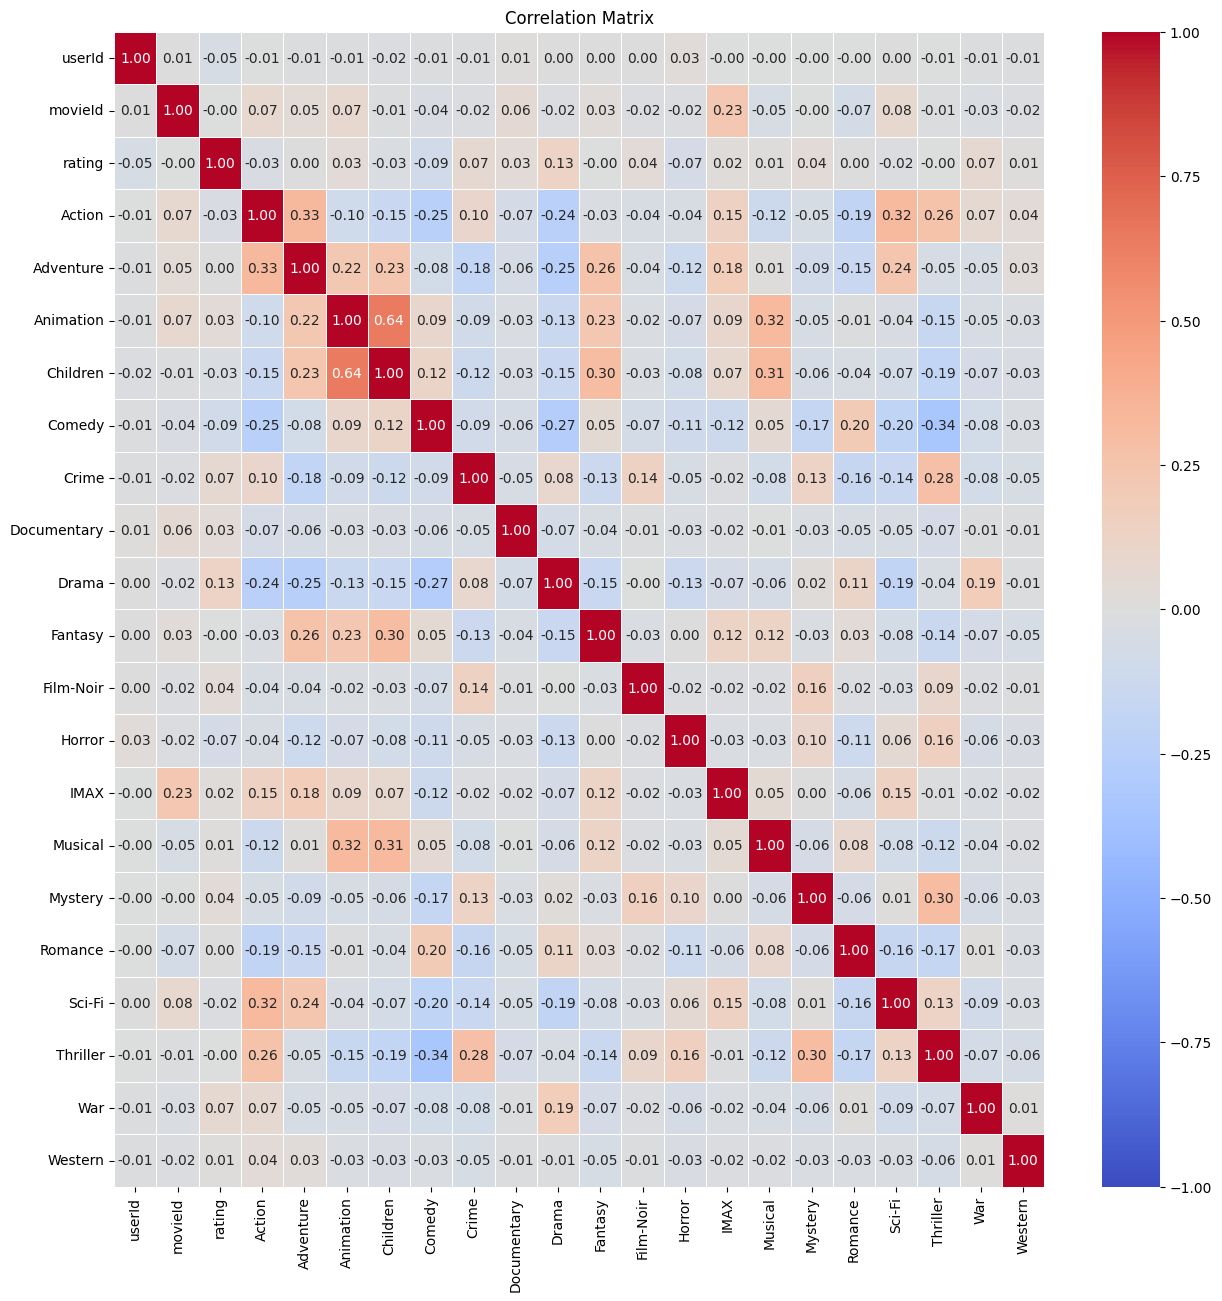

In [ ]:
# distribution plots of each relevant feature (userId, genre, rating, date)
plt.figure(figsize=(18, 15))

# userId
plt.subplot(3, 2, 1)
sns.histplot(data=df, x="userId")
plt.title("UserId Distribution")
plt.xlabel("UserId")
plt.ylabel("Number of Ratings")
plt.tight_layout()

# genre
plt.subplot(3, 2, 2)
genres = df.columns[5:]
genres_df = df[genres].sum().sort_values(ascending=False).reset_index()
genres_df.columns = ["genre", "count"]
sns.barplot(data=genres_df, x="genre", y="count")
plt.title("Movie Genres Distribution")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.tight_layout()

# rating
plt.subplot(3, 2, 3)
ratingBins = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
sns.histplot(data=df, x="rating", bins=ratingBins)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Total Ratings")
plt.tight_layout()

# date
plt.subplot(3, 2, 4)
df["day"] = df["date"].dt.date
dayCount_df = df.groupby("day").size().reset_index(name="count")
df = df.drop(columns="day")
sns.lineplot(data=dayCount_df, x="day", y="count")
plt.title("Date Distribution")
plt.xlabel("Date")
plt.ylabel("Number of Ratings")
plt.tight_layout()

# correlation matrix
plt.figure(figsize=(15, 15))
plt.subplot(1, 1, 1)
corr_df = df.iloc[:, list(range(0, 3)) + list(range(5, 24))]
correlationMatrix = corr_df.corr()
sns.heatmap(correlationMatrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix")

plt.show()

## Machine Learning Models

In [ ]:
# use scikit-learn's Surprise library to train some models
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

# load & split data to Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
surpriseData = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(surpriseData, test_size=0.2, random_state=11)

# create SVD model
svd_model = SVD()
cvResults = cross_validate(svd_model, surpriseData, measures=["RMSE", "MAE"], cv=5)

# test SVD model
print("Average RMSE:", cvResults["test_rmse"].mean())
print("Average MAE:", cvResults["test_mae"].mean())

# Define the dynamic grid search function
def dynamicGridSearch(data, baseParameters, param_grid, measure="rmse", threshold=0.001, max_iter=5):
    bestScore = float("inf")
    bestParameters = baseParameters
    grid = param_grid

    for i in range(max_iter):
        print(f"Iteration {i+1} with grid: {grid}")

        # Perform GridSearchCV
        gs = GridSearchCV(SVD, param_grid, measures=[measure], cv=5)
        gs.fit(data)

        # check if best score is substantial, then update it and parameters
        if gs.best_score[measure] < bestScore - threshold:
            bestScore = gs.best_score[measure]
            bestParameters = gs.best_params[measure]

            print(f"Improved {measure}: {bestScore}, Best Parameters: {bestParameters}")

            # update parameter grid
            grid = {
                "n_epochs": [max(5, bestParameters["n_epochs"] - 5), bestParameters["n_epochs"], bestParameters["n_epochs"] + 5],
                "lr_all": np.round(np.linspace(max(0.0001, bestParameters["lr_all"] / 2), bestParameters["lr_all"] * 2, 3), 6).tolist(),
                "reg_all": np.round(np.linspace(max(0.0001, bestParameters["reg_all"] / 2), bestParameters["reg_all"] * 2, 3), 6).tolist()
            }
        else:
            print("No significant improvement.")
            break

    return bestScore, bestParameters

# initial parameter grid
param_grid = {
    "n_epochs": [5, 10, 15],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.2, 0.4, 0.6]
}

# Base parameters (can be empty for the first iteration)
base_params = {}

# Perform adaptive grid search
bestRSME, bestParameters = dynamicGridSearch(surpriseData, base_params, param_grid, measure="rmse", threshold=0.001)
print("Best RMSE:", bestRSME)
print("Best Parameters:", bestParameters)



Average RMSE: 0.8736890907228103
Average MAE: 0.6713556373596044
Iteration 1 with grid: {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005, 0.01], 'reg_all': [0.02, 0.05, 0.1]}
Improved rmse: 0.8593310480419156, Best Params: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.05}
Iteration 2 with grid: {'n_epochs': [15, 20, 25], 'lr_all': [0.005, 0.0125, 0.02], 'reg_all': [0.025, 0.0625, 0.1]}
Improved rmse: 0.8503682450232329, Best Params: {'n_epochs': 25, 'lr_all': 0.02, 'reg_all': 0.1}
Iteration 3 with grid: {'n_epochs': [20, 25, 30], 'lr_all': [0.01, 0.025, 0.04], 'reg_all': [0.05, 0.125, 0.2]}
No significant improvement, stopping search.
Final Best RMSE: 0.8503682450232329
Final Best Parameters: {'n_epochs': 25, 'lr_all': 0.02, 'reg_all': 0.1}


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, confusion_matrix, f1_score, mean_squared_error
import shap

# Additional Model Development and Evaluation
print("\nDeveloping additional models for interpretability...")

# Create feature matrix for traditional ML approach
# This is needed for SHAP values and additional metrics
X = pd.concat([
    pd.get_dummies(df['userId'], prefix='user'),
    pd.get_dummies(df['movieId'], prefix='movie'),
    genreDummies
], axis=1)

y = df['rating']

# Split data for traditional ML approach
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model for SHAP values
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Calculate R2 score
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"\nR2 Score: {r2:.4f}")

# Create confusion matrix (by rounding predictions to nearest rating)
y_test_rounded = np.round(y_test)
y_pred_rounded = np.round(y_pred)
conf_matrix = confusion_matrix(y_test_rounded, y_pred_rounded)

# Calculate F1 score (macro average for multi-class)
f1 = f1_score(y_test_rounded, y_pred_rounded, average='macro')
print(f"F1 Score (macro): {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of Rounded Predictions')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

# SHAP Analysis
print("\nCalculating SHAP values...")
# Use a subset of data for SHAP analysis due to computational complexity
sample_size = min(1000, len(X_test))
X_test_sample = X_test.iloc[:sample_size]

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_sample)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('Feature Importance (SHAP Values)')
plt.tight_layout()
plt.show()

# Get top 10 most important features based on SHAP values
feature_importance = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

# Plot top 10 feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.xlabel('Average |SHAP Value|')
plt.tight_layout()
plt.show()

# Detailed SHAP analysis for top features
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, max_display=10, show=False)
plt.title('SHAP Value Distribution for Top Features')
plt.tight_layout()
plt.show()

/home/gabrielorbe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Developing additional models for interpretability...


KeyboardInterrupt: 

## Model Evaluation

In [27]:
userId = 3
movieId = 189713
prediction = svd_model.predict(userId, movieId)
print('Predicted rating:', prediction.est)

Predicted rating: 2.230874041797473
